# Take home exam

Machine Learning for Finance -- 2023 
VU Amsterdam    

**Instructors**  
Iman van Lelyveld (iman.van.lelyveld@vu.nl)  
Freek Henneken (f.j.henneken@student.vu.nl)
<span style='color:crimson; font-weight: bold'>Submission deadline: Friday, 22 Dec 2023, 24:00 pm CET</span>

In this exam we put the focus on interpretation and less on the technical parts. If any major unclarities arise, post them in the Canvas discussion `Take Home 2023`

----

<div style="font-size:24px; text-align:center; font-weight:bold">Good luck!</div>

----

# The Exam (100 points)

The case for this exam is Sentiment Analysis using Natural Language Processing (NLP). A regulator has given us a dataset with tweets on cryptocurrencies spanning from 11-01-2022 till 19-03-2022, and they'd like you to find out what the effect is of Twitter sentiment on Bitcion (BTC) prices. Using the daily BTC prices and a moving window of Twitter sentiment data, we're going to forecast the price of BTC after the moving window. We're not sure of the size of the impact of Twitter sentiment, but this is what the regulator would like us to find out.

In the report to the regulator, please discuss the impact your analysis supports as well as any concerns you might have (e.g., regarding bias, stability, etc.). As final product for the regulator, also make a widget that allows the regulator to choose which coins to include in the training set. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
# warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,plot_predict
import statsmodels.api as sm
%matplotlib inline
from ipywidgets import interact, widgets,HBox

## Preparation (30 points)

*10 points for selection function*

*5 points for relevance cryptocurrency*

*10 points for correct data aggregation*

*5 points for observing data*

The dataset has the following features:
* date, containing the time and date of the tweet;
* text, which is the whole tweet including hashtags;
* hashtags, which are the isolated hashtags in an array;
* tweet_source, specifying the platform the tweet was sent from.

Each tweet contains a number of hashtags, at least one on crypto. There can also be hashtags on other coins, NFTs or less relevant hashtags such as "gaming". The regulator would like to have a widget that can include certain hashtags in the training set, specifically on specific cryptocurrencies. Make a function that creates a dataset with all tweets on a selection of cryptocurrencies, e.g. if the selection is only on BTC, it should contain all tweets with widely-used hashtags 'btc', 'bitcoin', 'bitco', 'bitcoins' etc. If the selection is BTC and Ethereum (ETH), it should also contain all tweets with hashtags 'eth', 'ethereum', 'ethe' etc. 

The dataset contains tweets on many different cryptocurrencies, so make sure you specify such conditions for a good number of cryptocurrencies (at least 8). Briefly explain why each cryptocurrency would be relevant, per cryptocurrency.

For each tweet in the selected dataset, use *Vader* to get the sentiment of the tweet. Given the sentiment per tweet, create a daily average sentiment, where we use Market Close (5pm) as midnight. We bundle this with the daily BTC price at Market Close. Since a tweet at 17.01 is tweeted after market close, its sentiment doesn't influence the closing price of that day. Rather, it creates new sentiment for the opening price and the rest of that day. Also take into account that Twitter sentiment in the weekend should be included in Monday's sentiment.

Observe the finalized set of features, and comment on any outliers in both sentiment and closing prices. Also comment on the most used hashtags (aside from the hashtags on crypto and decentralized finance).

In [2]:
df = pd.read_csv('2690485_ML4F_TakeHomeData2023.csv')

In [3]:
df.head() #check the data

,date,text,hashtags,tweet_source
0,2022-01-11 00:00:00,"#Tesla has created over 50,000 US jobs buildi...","['Tesla', 'doge', 'twitter']",Twitter for iPhone
1,2022-01-11 00:00:00,The probability of #Tesla dying in 2008/2009 ...,"['Tesla', 'money', 'eth']",Twitter for iPhone
2,2022-01-11 00:01:00,Encryption has brought us a lot of surprises a...,"['BTC', 'ETH', 'usdtry', 'CryptoNews', 'Ada', ...",Twitter Web App
3,2022-01-11 00:01:00,👑Psycho Ape is an exclusive collection of uniq...,"['NFTCommunity', 'NFTGiveaway', 'art', 'NFTdro...",Twitter for iPhone
4,2022-01-11 00:02:00,🤜🤛Welcome our New Partner - @BlockchainCutie- ...,"['crypto', 'FARCANA', 'BTC', 'P2E', 'Blockchai...",Twitter Web App


### 1A selection function/1B relevance cryptocurrency

The 'selected_coin_analyzer' can select the tweets based on the coin tags and thresholds and then calculate their sentiments.It selects the tweets that have at least x (thresholds) tags from given coin tags. For instance, with coin_tags = ['BTC', 'ETH'], a threshold of 1 would result in the selection of tweets containing either bitcoin or ethereum. Meanwhile, a threshold of 2 would lead to the selection of tweets containing both bitcoin and ethereum.

For bitcoin, it can be either BTC,XBT which are the abbrivation of bitcoin, or BIT, then and tags contain BIT will be selected, e.g. BITCOIN,BIT,BITC. Although this may have risk to select something like ABCBIT123 since 'BIT' is in this tag, it is the most efficient way to select bitcoin tags out of all tags with regard to bitcoin cryptocurrency.

For 'USDT','BNB','XRP','USDC','ADA',since their abbrivations are different from their company names, the names of their company will also be considerd.

For 'ETH' and 'SOL', their company names and other forms of abbrivations all contain 'ETH' or 'SOL', so no additional tags are specified.

These cryptocurrenciews are the most famous 8 which has the largest volumes, so the function itself can detect them and include the other possibilities of abbrivations. 

In [4]:
def selected_coin_analyzer(df, coin_tags = ['BTC','ETH','USDT','BNB','XRP','SOL','USDC','ADA','DOGE'], threshold=3):
    df['hashtags'] = df['hashtags'].str.upper() #Set all string to upper case.
    df_selection = pd.DataFrame(columns=df.columns)
    df_selection['sentiment'] = np.NaN #create space for sentiment
    selection_idx = 0
    SIA = SentimentIntensityAnalyzer()
    
    conditions_list = []
    for index, row in df.iterrows(): 
        hashtag = row['hashtags']
        conditions = [(coin_tag == 'BTC' and ('BTC' in hashtag or 'BIT' in hashtag or 'XBT' in hashtag)) or
                      (coin_tag == 'USDT' and ('USDT' in hashtag or 'TETHER' in hashtag)) or
                      (coin_tag == 'BNB' and ('BNB' in hashtag or 'BINANCE' in hashtag)) or
                      (coin_tag == 'XRP' and ('XRP' in hashtag or 'RIPPLE' in hashtag)) or
                      (coin_tag == 'USDC' and ('USDC' in hashtag or 'CIRCLE' in hashtag)) or
                      (coin_tag == 'ADA' and ('ADA' in hashtag or 'CARDANO' in hashtag)) or                 
                      (coin_tag != 'BTC' and coin_tag != 'USDT' and coin_tag != 'BNB' and 
                       coin_tag != 'XRP' and coin_tag != 'USDC' and coin_tag != 'ADA' and 
                       coin_tag in hashtag) for coin_tag in coin_tags]
        # If the most famous cryptocurrencies are entered, then create alternative tags for them.
        conditions_list.append(conditions)

    conditions_matrix = np.column_stack(conditions_list) 
    selection_mask = np.sum(conditions_matrix, axis=0) >= threshold #create a mask that decide which tweets to be picked.
    df_selection = df[selection_mask].copy()
    df_selection['sentiment'] = df_selection['text'].apply(lambda x: SIA.polarity_scores(text=x)['compound']) #calculate the sentiment.
    df_selection['sentiment'] = pd.to_numeric(df_selection['sentiment'])
    return df_selection


### 1C data aggregation


The 'trading_date' function maps real-time values to their respective trading dates. If the day of the week is between 0 and 4 (Monday to Friday) and the time is before 17:00, then the trading date is equivalent to the real date. Else if it's Monday to Thursday after 17:00, the trading date is set to the real date plus 1. For Fridays, the trading date is calculated as the real date plus 3. Saturdays and Fridays result in a trading date of the real date plus 2 and 1 respectively.

In [5]:
def trading_date(df_selected):
    df_selected['trading_date'] = np.NaN
    for index, row in df_selected.iterrows():
        actual_date = pd.to_datetime(row['date'])
        day_of_week = actual_date.dayofweek
        day = actual_date.date()
        hour = actual_date.hour

        if 0<=day_of_week<=4:
            if hour < 17:
                df_selected['trading_date'].loc[index] = day
            elif day_of_week == 4:
                df_selected['trading_date'].loc[index] = day + timedelta(days=3)
            else:
                df_selected['trading_date'].loc[index] = day + timedelta(days=1)
        elif day_of_week == 5:
            df_selected['trading_date'].loc[index] = day + timedelta(days=2)
        elif day_of_week == 6:
            df_selected['trading_date'].loc[index] = day + timedelta(days=1)   
    return df_selected

In [6]:
df_selected = selected_coin_analyzer(df,coin_tags=['BTC'],threshold=1)

In [7]:
df_selected = trading_date(df_selected)

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_21036\3054531837.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['trading_date'].loc[index] = day


Group the sentiment by trading date to get the daily sentiment.

In [8]:
df_sentiment = df_selected.groupby('trading_date').mean(numeric_only=True)

Get the bitcoin price and then merge with the sentiment, so the dateset containing bitcoin close price and their corresponding daily sentiment is built.

In [9]:
df_btc = pd.read_csv('BTC-USD.csv')
df_btc['Date']=pd.to_datetime(df_btc['Date'])
df_btc = df_btc.set_index(['Date'])
df_btc_senti = pd.merge(df_sentiment, df_btc['Close'],left_index=True, right_index=True, how='inner')
#df_btc_senti.to_csv('df_btc_senti.csv')

In [10]:
#df_btc_senti = pd.read_csv('df_btc_senti.csv')
#df_btc_senti['Unnamed: 0'] = pd.to_datetime(df_btc_senti['Unnamed: 0'])
#df_btc_senti.set_index('Unnamed: 0', inplace=True)
#df_btc_senti.index.name = None

### 1D observing data

The boxplot shows that the daily sentiment exhibits only one outlier, while the close price shows no outliers. This suggests a relative stability in sentiment throughout the observation period. It implies that there may not have been any news or events causing significantly low or high sentiment about bitcoin. Similarly, the absence of outliers in the close price indicates a stable trend, with no significant drops or increases in the bitcoin price. Additionally, the plot does not provide a clear indication of the relationship between sentiment and bitcoin price.

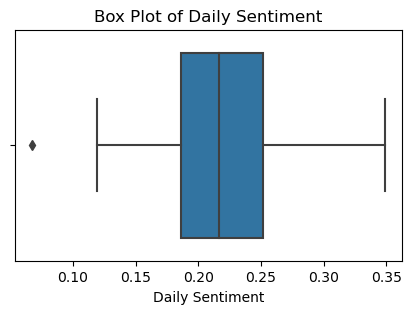

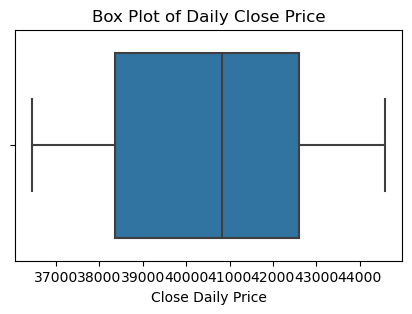

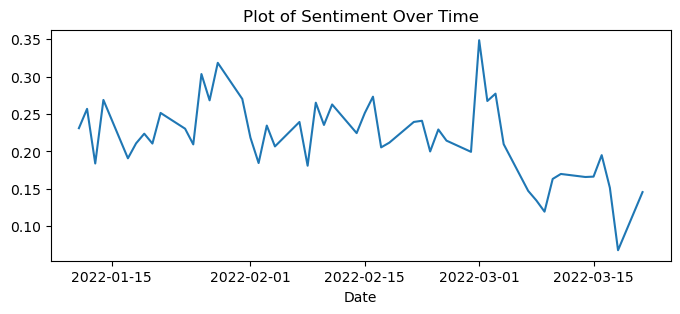

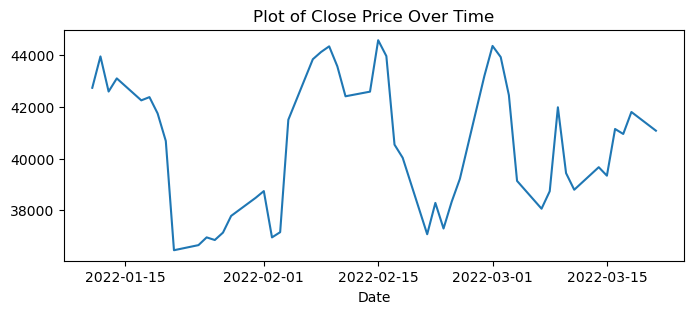

In [11]:
plt.figure(figsize=(5, 3))
sns.boxplot(x=df_btc_senti['sentiment'])
plt.title(f'Box Plot of Daily Sentiment')
plt.xlabel('Daily Sentiment')
plt.show()
plt.figure(figsize=(5, 3))
sns.boxplot(x=df_btc_senti['Close'])
plt.title(f'Box Plot of Daily Close Price')
plt.xlabel('Close Daily Price')
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(df_btc_senti['sentiment'])
plt.title(f'Plot of Sentiment Over Time')
plt.xlabel('Date')
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(df_btc_senti['Close'])
plt.title(f'Plot of Close Price Over Time')
plt.xlabel('Date')
plt.show()

Since the tweets are already selected to be cryptorelated, most used hashtags are about different types of cryptos. The first unrelated hashtags is 'METAVERSE: 9875' and the second is 'AIRDROP: 5758'. This indicates that people who sends crypto-related tweets may also be interested in cyber security and other decentralized concepts despite decentralized finance. This raises concerns about potential bias, as the information of interest may differ. Their specific interests might influence the decision their made on the bitcoin trading.

In [12]:
hashtag_counts = {}
for index, row in df.iterrows():
    hashtags = row['hashtags'].upper()
    hashtag_list = [tag.strip(" '[]") for tag in hashtags.split(',')]
    for hashtag in hashtag_list:
        hashtag_counts[hashtag] = hashtag_counts.get(hashtag, 0) + 1

for hashtag, count in sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{hashtag}: {count}")

BITCOIN: 97260
BTC: 95793
CRYPTO: 35313
ETH: 27803
NFT: 19768
CRYPTOCURRENCY: 19386
ETHEREUM: 15008
BNB: 13002
NFTS: 11709
BINANCE: 10915
BSC: 10776
DEFI: 9998
METAVERSE: 9875
BLOCKCHAIN: 7659
NFTCOMMUNITY: 6367
AIRDROP: 5758
SOLANA: 5055
SHIB: 4844
CRYPTONEWS: 4812
DOGE: 4599
XRP: 4059
ALTCOINS: 3822
CRYPTOCURRENCIES: 3715
ALTCOIN: 3588
USDT: 3574
BSCGEM: 3430
POLYGON: 3347
NFTART: 3333
WEB3: 2921
MATIC: 2861
ADA: 2815
AVAX: 2627
OPENSEA: 2613
1000XGEM: 2612
DOGECOIN: 2572
CRYPTOCRASH: 2562
TRADING: 2524
NFTCOLLECTOR: 2293
SHIBA: 2276
NFTARTIST: 2182
CRYPTOTRADING: 2176
SOL: 2171
BITCOINCRASH: 2166
LIGHTNINGNETWORK: 2163
NFTDROP: 2103
NFTGIVEAWAY: 2090
LN: 1988
BOLTCOINER: 1979
AIRDROPS: 1821
CRYPTOCURRECY: 1808
COINBASE: 1807
IDO: 1766
HODL: 1741
BINANCESMARTCHAIN: 1667
NFTCOLLECTION: 1632
NFTPROJECT: 1572
MONEY: 1559
SAITAMA: 1555
ART: 1542
CARDANO: 1490
SHINJA: 1461
BLUESPARROW: 1403
LAUNCHPAD: 1401
BULLISH: 1367
ELONMUSK: 1363
DOT: 1355
NFTCOLLECTORS: 1345
CRYPTOS: 1340
BITCOINBUT

## Forecasting (25 points)

*10 points for moving window function*

*15 points for metrics*

Now that we have a proper set of features, we obtain the daily BTC closing price from YahooFinance. Create a function such that we can select a specific period of time (a week, 2 weeks, a month, etc.). This way, we can perform a Moving Window forecast. The specified window of time becomes our training set, and the day after this window is the test set. 

We would like to examine three different Regression models for their ability to capture and predict time series: a Decision Trees model (DT), a Long Short-Term Memory model (LSTM) and an Auto-Regressive Integrated Moving Average model (ARIMA). The DT model can be found on SKLearn, but the LSTM and ARIMA models are available in other libraries.

Using these models, forecast BTC prices using weekly, bi-monthly and monthly data (assume that a month is 4 weeks, and that a week is 5 days). Compute the average Mean Absolute Percent Error (MAPE) for each model, for each window size, and comment on their differences and comparability. Also make a decision on which model is the optimal model for this project. 

### 2A  Moving window function

The moving window function returns training set from the start index with n (window size) data, and n+1 th data after the start index as the test data. The index is the location index in the dataframe instead of date, so that the weekend can be skipped. Using the for loop from 0 to (length of dataframe - window size), the Moving Window forecast can be performed to all the data in the dataframe.

In [13]:
def moving_window(df,start_index,window_size=None):
    
    if start_index + window_size >= len(df):
        raise ValueError("Not enough data points after the start date for the specified window size.")
        
    end_index = start_index + window_size
    df_train = df.iloc[start_index:end_index] 
    df_test = df.iloc[end_index:end_index+1]
    return df_train, df_test

### 2B Metrics

The following codes perform decision tree regression for weekly, bi-monthly and monthly data. It can be concluded that weekly data has the lowest MAPE, which is the best. However, since there is only one feature, all models do not have any predictive power and all of them predict the price randomly. Therefore, the decision tree does not work for this problem

In [14]:
def decisiontree(df,window_size):
    ape_list = []
    y_train_list = []
    y_pred_list = []
    y_test_list = []
    for i in range(len(df_btc_senti)-window_size):
        df_train,df_test = moving_window(df_btc_senti,i,window_size=window_size)
        y_train = df_train['Close']
        y_train_list.append(y_train)
        x_train = df_train.drop('Close',axis=1)
        y_test = df_test['Close']
        y_test_list.append(y_test)
        x_test = df_test.drop('Close',axis=1)
        dtr = DecisionTreeRegressor()
        dtr.fit(x_train, y_train)
        y_pred = dtr.predict(x_test)
        y_pred_list.append(y_pred)
        ape = mean_absolute_error(y_test, y_pred)/np.abs(y_pred)
        ape_list.append(ape)
    sns.scatterplot(x=np.concatenate(y_test_list), y=np.concatenate(y_pred_list))
    plt.plot([min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             [min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             linestyle='--', color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values for Decision Tree Regressor')
    plt.show()
    mean_mape = np.mean(ape_list)
    print(f'Mean Absolute Percentage Error (MAPE): {mean_mape:.4f}')
    plt.plot(y_test_list, label='Test')
    plt.plot(y_pred_list, label='Forecast', color='red')
    plt.title('Test vs Forcast of Bitcoin Price for Decision Tree Regressor')
    plt.xlabel('i-th Prediction')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

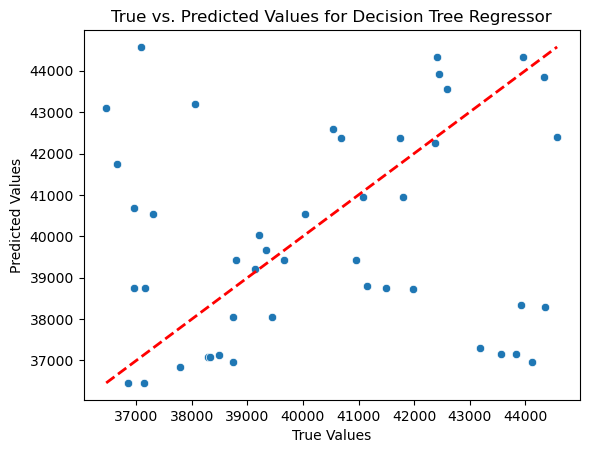

Mean Absolute Percentage Error (MAPE): 0.0602


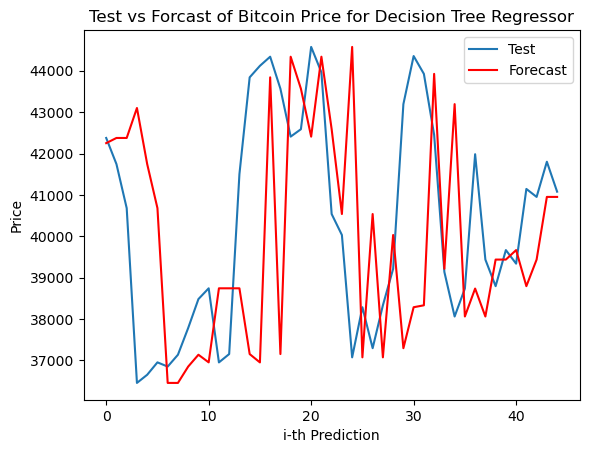

In [15]:
decisiontree(df_btc_senti,5)

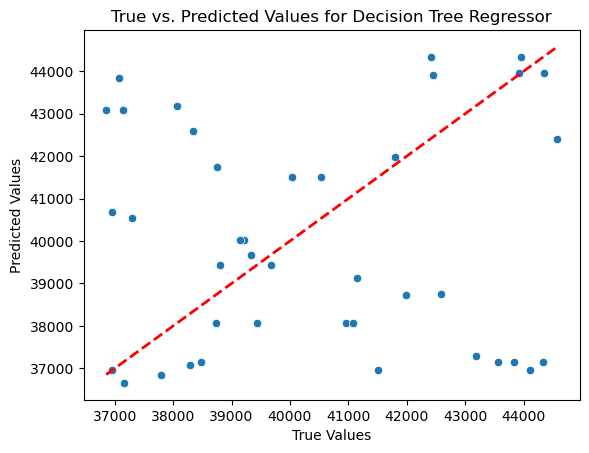

Mean Absolute Percentage Error (MAPE): 0.0689


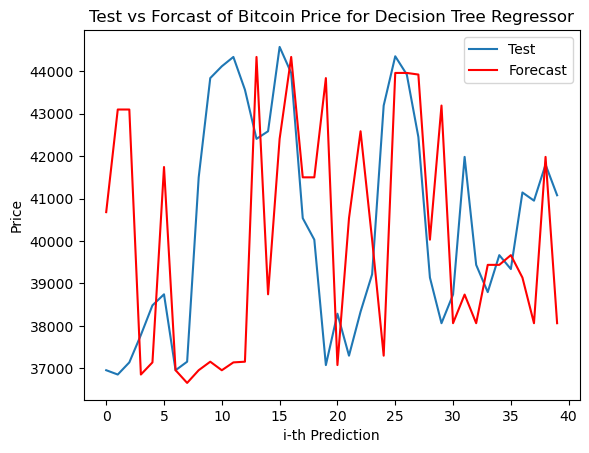

In [16]:
decisiontree(df_btc_senti,10)

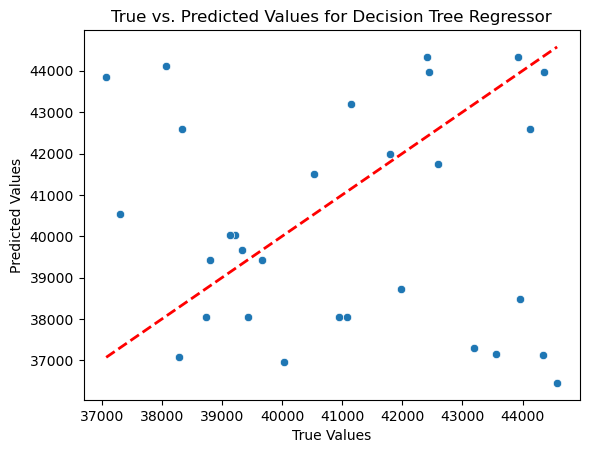

Mean Absolute Percentage Error (MAPE): 0.0690


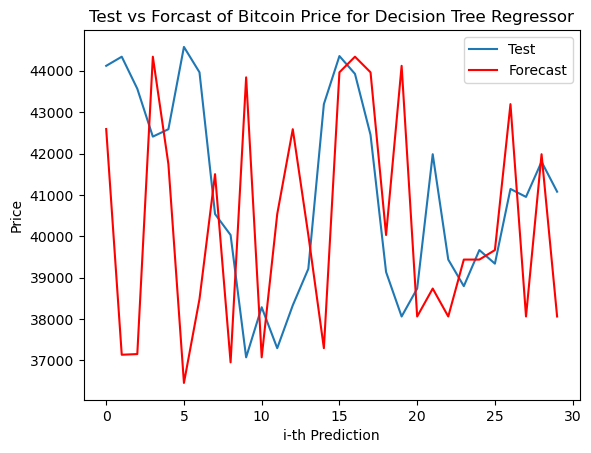

In [17]:
decisiontree(df_btc_senti,20)

The following codes perform decision LSTM for weekly, bi-monthly and monthly data. It can be concluded that monthly data has the lowest MAPE, which is the best. However, like the decision trees, the model still does not have much predictive power. However, LSTM may capture the sequential dependencies in data, so it performs slightly better than the decision tree model.

In [18]:
def lstm(df,window_size):
    warnings.filterwarnings("ignore")
    ape_list = []
    y_train_list = []
    y_pred_list = []
    y_test_list = []
    for i in range(len(df_btc_senti)-window_size):
        df_train,df_test = moving_window(df_btc_senti,i,window_size=window_size)
        y_train = df_train['Close']
        y_train_list.append(y_train)
        x_train = df_train.drop('Close',axis=1)
        y_test = df_test['Close']
        y_test_list.append(y_test)
        x_test = df_test.drop('Close',axis=1)

        scaler_x = MinMaxScaler()
        x_train_scaled = scaler_x.fit_transform(x_train)
        x_test_scaled = scaler_x.transform(x_test)

        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

        lstm = Sequential()
        lstm.add(LSTM(50, input_shape=(x_train_scaled.shape[1], 1)))
        lstm.add(Dense(1))
        lstm.compile(optimizer='adam', loss='mae')
        lstm.fit(x_train_scaled, y_train_scaled, epochs=400, verbose=0)

        y_pred_scaled = lstm.predict(x_test_scaled,verbose=0).reshape(-1, 1)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_pred_list.append(y_pred[0][0])
        ape = mean_absolute_error(y_test, y_pred)/np.abs(y_pred)
        ape_list.append(ape)
    sns.scatterplot(x=np.concatenate(y_test_list), y=y_pred_list)
    plt.plot([min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             [min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             linestyle='--', color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values for LSTM')
    plt.show()

    # Calculate the mean MAPE
    mean_mape = np.mean(ape_list)
    print(f'Mean Absolute Percentage Error (MAPE): {mean_mape:.4f}')
    plt.plot(y_test_list, label='Test')
    plt.plot(y_pred_list, label='Forecast', color='red')
    plt.title('Test vs Forcast of Bitcoin Price for LSTM')
    plt.xlabel('i-th Prediction')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

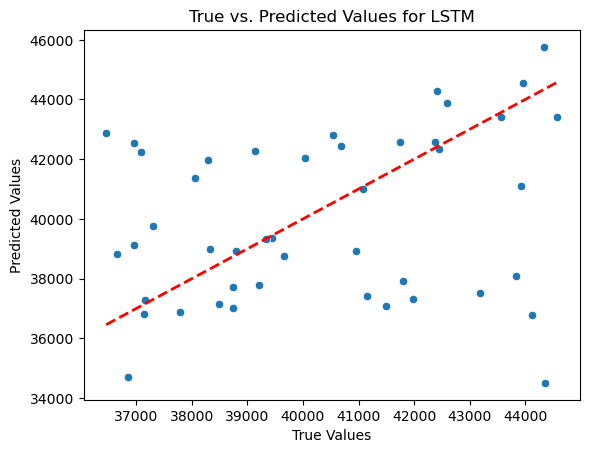

Mean Absolute Percentage Error (MAPE): 0.0618


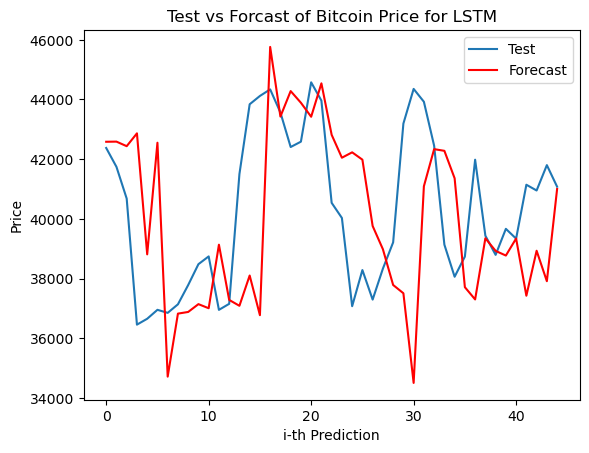

In [19]:
lstm(df_btc_senti,5)

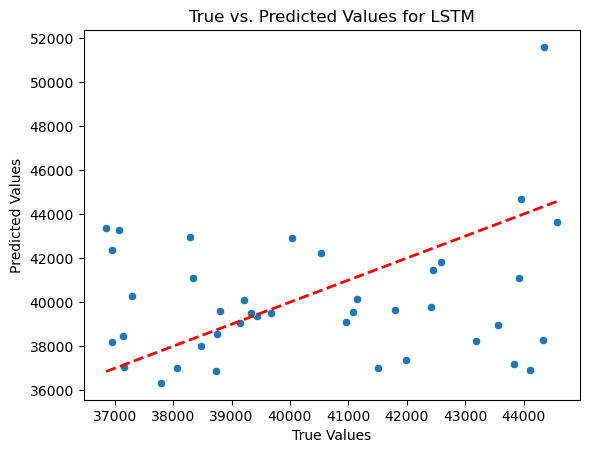

Mean Absolute Percentage Error (MAPE): 0.0647


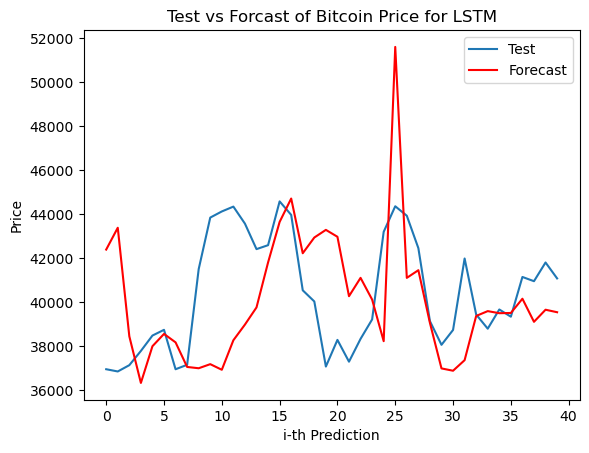

In [20]:
lstm(df_btc_senti,10)

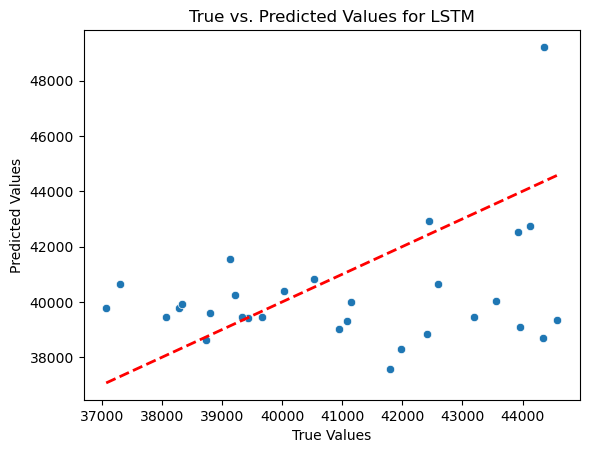

Mean Absolute Percentage Error (MAPE): 0.0543


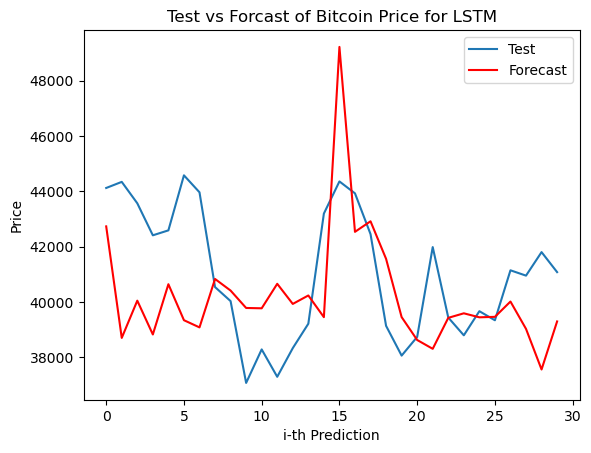

In [21]:
lstm(df_btc_senti,20)

The following codes perform decision ARMA(3,3) for weekly, bi-monthly and monthly data. It is noticeable that the return is stationary while the price itself is not. Therefore, performing time series model on price may be not an ideal chocie. From the ACF and PACF graph, the autocorrelation and partial autocorrelation are both insignificant after lag(3), so the ARMA(3,3) is used. The weekly data has the lowest MAPE and it is better than the best models in decision trees and LSTM. Therefore, it is the best model. However, from the plot of the forecast, it can be seen that the model tends to predict the price the next day with the price of the previous day. It is better than the random prediction in decision tree and LSTM, but the result is still not ideal. Additionally, since it is time series, it does not take the sentiment into consideration. (The ARMA33-X models are also tested, but the time series model performs even worse with sentiment. Therefore, they are not used.) 

In [22]:
def ARMA33(df,window_size):
    warnings.filterwarnings("ignore")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(df['Close'], lags=10, ax=ax1, title='ACF for y_train')
    plot_pacf(df['Close'], lags=10, ax=ax2, title='PACF for y_train')
    plt.show()
    ape_list = []
    y_train_list = []
    y_pred_list = []
    y_test_list = []
    for i in range(len(df)-window_size):
        df_train,df_test = moving_window(df_btc_senti,i,window_size=window_size)
        y_train = df_train['Close']
        y_train_list.append(y_train)
        x_train = df_train.drop('Close',axis=1)
        y_test = df_test['Close']
        y_test_list.append(y_test)
        x_test = df_test.drop('Close',axis=1)
        ts = sm.tsa.SARIMAX(y_train, order=(3, 1, 3))
        ts_fit = ts.fit()
        y_pred  = ts_fit.forecast(steps=1)
        y_pred_list.append(y_pred)
        ape = mean_absolute_error(y_test, y_pred)/np.abs(y_pred)
        ape_list.append(ape)
    sns.scatterplot(x=np.concatenate(y_test_list), y=np.concatenate(y_pred_list))
    plt.plot([min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             [min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             linestyle='--', color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values for ARIMA')
    plt.show()
    mean_mape = np.mean(ape_list)
    print(f'Mean Absolute Percentage Error (MAPE): {mean_mape:.4f}')
    plt.plot(y_test_list, label='Test')
    plt.plot(y_pred_list, label='Forecast', color='red')
    plt.title('Test vs Forcast of Bitcoin Price for with ARIMA')
    plt.xlabel('i-th Prediction')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [23]:
def ARMA33X(df,window_size):
    warnings.filterwarnings("ignore")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(df['Close'], lags=10, ax=ax1, title='ACF for y_train')
    plot_pacf(df['Close'], lags=10, ax=ax2, title='PACF for y_train')
    plt.show()
    ape_list = []
    y_train_list = []
    y_pred_list = []
    y_test_list = []
    for i in range(len(df)-window_size):
        df_train,df_test = moving_window(df_btc_senti,i,window_size=window_size)
        y_train = df_train['Close']
        y_train_list.append(y_train)
        x_train = df_train.drop('Close',axis=1)
        y_test = df_test['Close']
        y_test_list.append(y_test)
        x_test = df_test.drop('Close',axis=1)
        ts = sm.tsa.SARIMAX(y_train, order=(3, 1, 3),exog=x_train)
        ts_fit = ts.fit()
        y_pred  = ts_fit.forecast(steps=1,exog=x_test)
        y_pred_list.append(y_pred)
        ape = mean_absolute_error(y_test, y_pred)/np.abs(y_pred)
        ape_list.append(ape)
    sns.scatterplot(x=np.concatenate(y_test_list), y=np.concatenate(y_pred_list))
    plt.plot([min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             [min(np.concatenate(y_test_list)), max(np.concatenate(y_test_list))], 
             linestyle='--', color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs. Predicted Values for ARIMAX')
    plt.show()
    mean_mape = np.mean(ape_list)
    print(f'Mean Absolute Percentage Error (MAPE): {mean_mape:.4f}')
    plt.plot(y_test_list, label='Test')
    plt.plot(y_pred_list, label='Forecast', color='red')
    plt.title('Test vs Forcast of Bitcoin Price for with ARIMAX')
    plt.xlabel('i-th Prediction')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

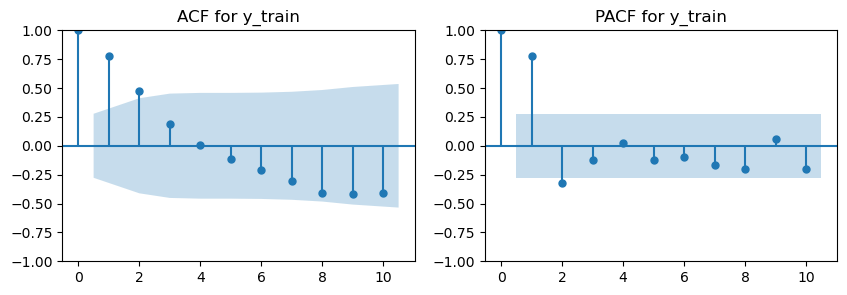

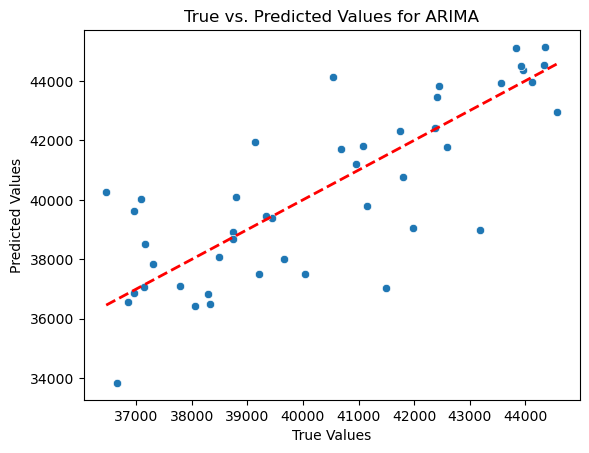

Mean Absolute Percentage Error (MAPE): 0.0337


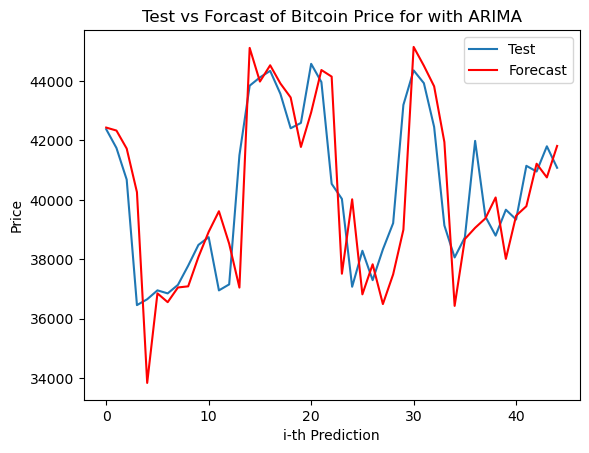

In [24]:
ARMA33(df_btc_senti,5)

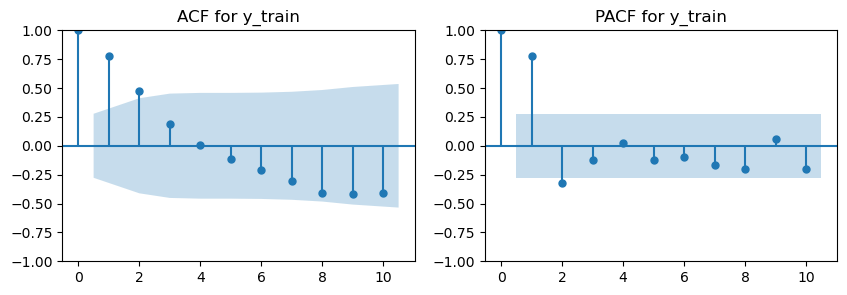

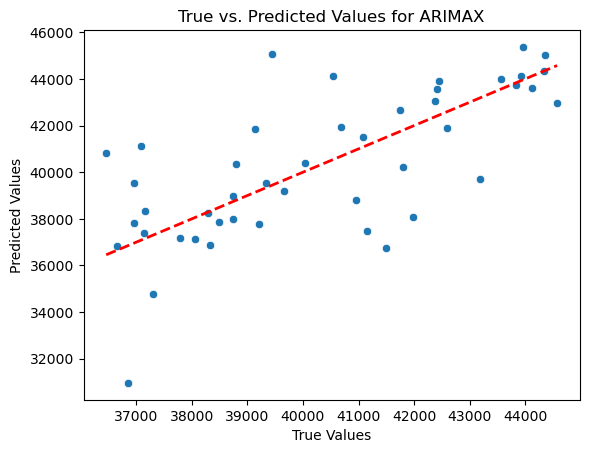

Mean Absolute Percentage Error (MAPE): 0.0417


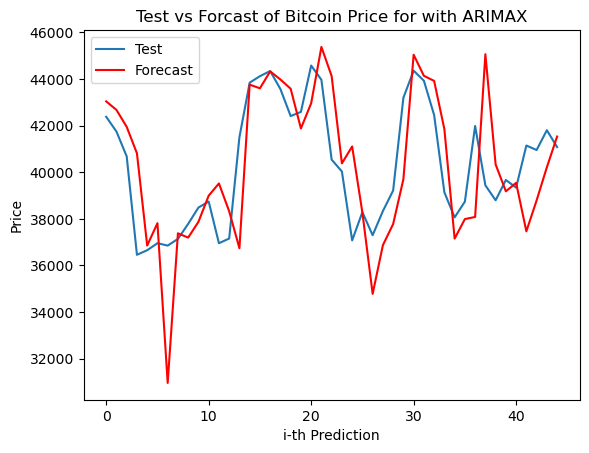

In [25]:
ARMA33X(df_btc_senti,5)

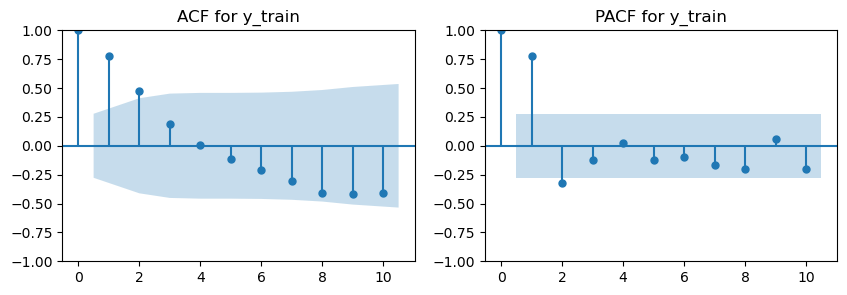

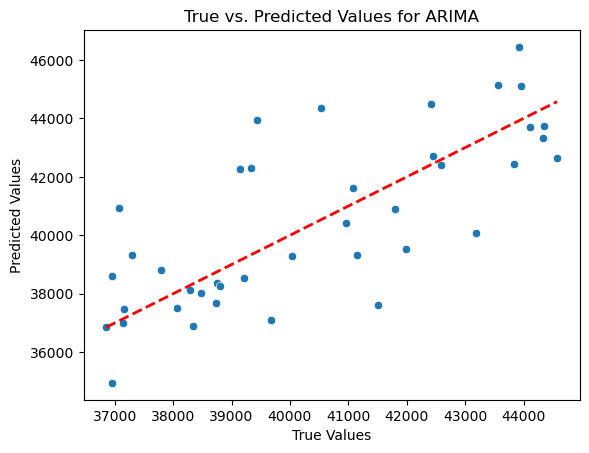

Mean Absolute Percentage Error (MAPE): 0.0371


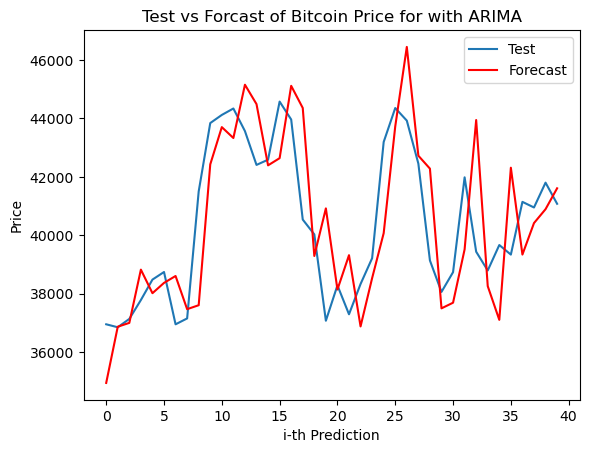

In [26]:
ARMA33(df_btc_senti,10)

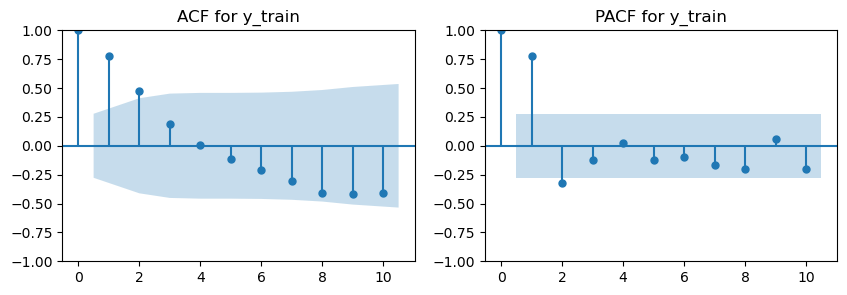

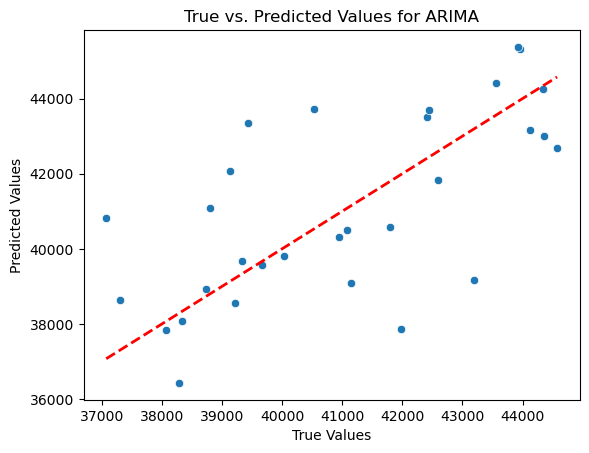

Mean Absolute Percentage Error (MAPE): 0.0364


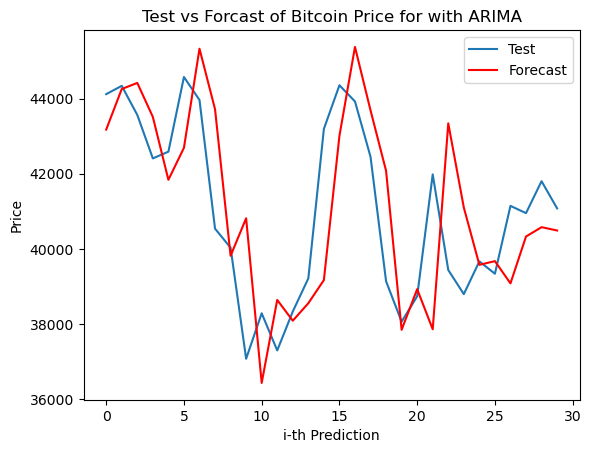

In [27]:
ARMA33(df_btc_senti,20)

In conclusion, the ARMA(3,3) model using weekly data is the best model for this project. 

## Concerns (25 points)

*10 points for influencer bias*

*15 points for political bias*

Suppose a very influential person's tweets were to be included in the dataset. Their tweets are retweeted and suggested to other users far more often than regular tweets, however hyped up these tweets might be. If the influencer's tweets would be labeled (regular users labeled '0' and the tweets of influencer '1'), would you need to account for this effect? Why would you and how would you do it? Explain your steps and methods. **Note:** this is a hypothetical case. A bonus of 5 points can be received for implementing it in a correct manner, but no points will be reduced if not.

When you inspect the different hashtags, you see that there are mostly (decentralized) finance related hashtags. Next to these hashtags, there are also a lot of political hashtags, for example regarding recent political conflicts. Tweets with these type of hashtags might have a different effect on BTC prices. Seperate your dataset by politically loaded tweets, and observe the difference in effect. 

### 3A influencer bias

The influencer bias should be considered definitely. The influencer's tweet can be seen by more people and trusted by more people, thus it may affect more on bitcoin investors' decisions, which will then affect the bitcoin price. Therefore, more weights should be assigned to those tweets. One method is to copy the influencers' tweets by mutiple times. When calculating the daily sentiment, there will be mutiple sentiment scores from the same tweet sent by influencers, so their scores have a larger weights when calculating the daily sentiments. The following function duplicates influencers' tweets by 3 times and return the dataframe.

Also, it is worth mentioning that the level of influencers are different. Elon Musk's tweet that announces that Tesla cannot be paid by bitcoin would be much more influential than some rational comments on bitcoins from some famous politicians.

In [28]:
def influencer(df):
    df_weighted = pd.concat([df[df['influcener'] == 1]] * 3 + [df[df['influcener'] == 0]])
    df_weighted = df_weighted.reset_index(drop=True)
    return df_weighted

### 3B political bias

Politics is a very complicated factor that can either postively or negatively affect the bitcoin price. Back to the days of our sample period, Russian Ukraine crisis may lead to more demand in bitcoins as the Russians and Ukrainians may less trustworthy about their currency and there might be more black markets trade on weapons, which might use bitcoin. On the other hand, Russians also plays a role in bitcoin mining, so their involve in wars may negatively affect bitcoin mining.

However, it is worth mentioning that there is no political issues that is directly related to bitcoin in given period. In May 2021, China bans the bitcoin completely and Elon Musk refuses to use bitcoin as Tesla payment. These political issues may be more related to bitcoin price.

Also, if there is worldwide political issue, it may cause the general sentiment becoming high or low. For example, a terrorist attack may cause everybody in low sentiment, so the sentiment score of that day may be unexpectedly low. On the other hand, it does not necessarily affect the bitcoin price. This situation may also lead to bias.

In [29]:
df_politics = selected_coin_analyzer(df, coin_tags = ['RUSSIA','UKRAINE','USA','ELSALVADOR','DUBAI',
     'COVID', 'POVERTY','INDIA','OILANDGAS','CHINA','JAPAN','AUSTRALIA'], threshold=1)

In [30]:
df_politics = trading_date(df_politics)
df_politics_grouped = df_politics.groupby('trading_date').mean(numeric_only=True)
df_btc = pd.read_csv('BTC-USD.csv')
df_btc['Date']=pd.to_datetime(df_btc['Date'])
df_btc = df_btc.set_index(['Date'])
df_poli_senti = pd.merge(df_politics_grouped, df_btc['Close'],left_index=True, right_index=True, how='inner')

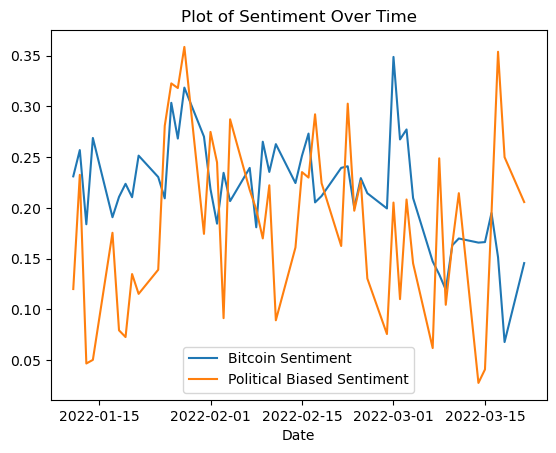

In [31]:
plt.plot(df_btc_senti.index,df_btc_senti['sentiment'],label='Bitcoin Sentiment')
plt.plot(df_poli_senti['sentiment'],label='Political Biased Sentiment')
plt.legend()
plt.title(f'Plot of Sentiment Over Time')
plt.xlabel('Date')
plt.show()

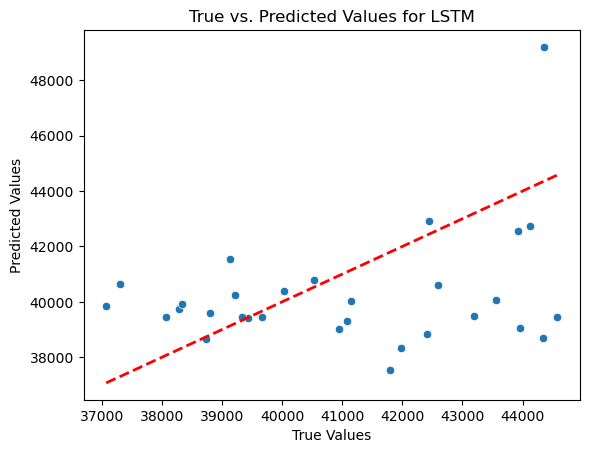

Mean Absolute Percentage Error (MAPE): 0.0542


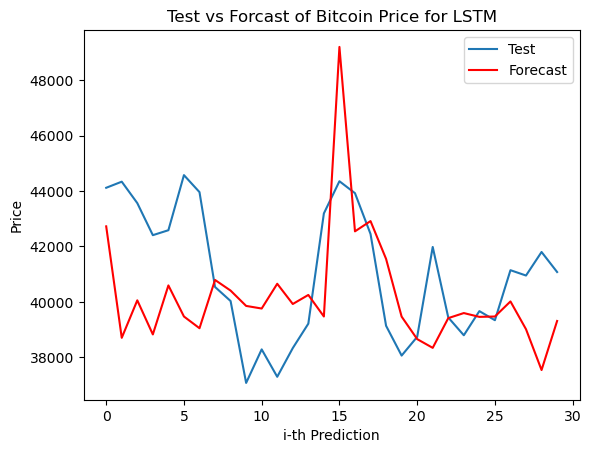

In [32]:
lstm(df_poli_senti,20)

## Recommendation (20 points)

*10 points for widgets*

*10 points for the report*

The regulator would like to have a tool to adjust the included crypto-hashtags in the dataset. Make two seperate widgets:
* A slider that includes only BTC hashtags on the left, and the more it goes to the right, the more, increasingly less popular cryptohashtags it includes;
* A number of checkboxes, to in/exclude the different crypto's manually.

**Note:** these widgets cannot perform together at the same time. Make sure to call them seperately. 

Now that you've made an assessment of the impact of Twitter sentiment on BTC prices, it is time to write a recommendation to the regulator. Explain what you have researched and present your results and concerns in a short paper in no more than 400 words. 

Focus on what might concern the regulator, and minimize the technical talk. We recommend writing in LaTeX/Overleaf, but Word or another application is also fine. Hand the paper in as PDF, together with your Jupyter Notebook, in a ZIP-file.

In [33]:
coin_tags_list = ['BTC', 'ETH', 'USDT', 'BNB', 'XRP', 'SOL', 'USDC', 'ADA', 'DOGE']

def update_hashtags(hashtags):
    hashtags = int(hashtags)  # Convert to integer
    selected_coin_tags = coin_tags_list[:hashtags]
    return selected_coin_tags

## if there is bug in display the widgets, maybe rerunning the cell would work.

hashtags_slider = widgets.FloatSlider(min=1, max=len(coin_tags_list), step=1, value=0)
selected_coin_tags_slider= interact(update_hashtags, hashtags=hashtags_slider)


interactive(children=(FloatSlider(value=1.0, description='hashtags', max=9.0, min=1.0, step=1.0), Output()), _…

In [34]:
selected_coin_tags = selected_coin_tags_slider.widget.result
print("Selected Coin Tags:", selected_coin_tags)

Selected Coin Tags: ['BTC']


In [35]:
def update_hashtags(**kwargs):
    selected_coin_tags = [coin for coin, include in kwargs.items() if include]
    return selected_coin_tags

# Create a checkbox for each cryptocurrency
checkboxes = {coin: widgets.Checkbox(value=True, description=coin) for coin in coin_tags_list}

# Add the checkboxes to the interact function
selected_coin_tags_box = interact(update_hashtags, **checkboxes)

interactive(children=(Checkbox(value=True, description='BTC'), Checkbox(value=True, description='ETH'), Checkb…

In [36]:
selected_coin_tags = selected_coin_tags_box.widget.result
print("Selected Coin Tags:", selected_coin_tags)

Selected Coin Tags: ['BTC', 'ETH', 'USDT', 'BNB', 'XRP', 'SOL', 'USDC', 'ADA', 'DOGE']
